## With DQN replay memory (SGD optimizer)

In [1906]:
import gym
#import roboschool
from environment import Environment
from agent import Agent, Transition
from trainer import Final_variational_trainer, Q_learning_trainer
import matplotlib.pyplot as plt
import numpy as np
import math

**PLUS KL!!**

``loss_Q_var = torch.sum(0.5 * self.agent.PREC *  torch.pow(Q_var_pred_tf - sum_future_rewards_tf, 2) 
                       + 0.5 / self.agent.BETA * torch.pow(Q_var_pred_tf + loss_KL_tf_list.view((current_batch_size, 1) - Q_var_pred_tf.detach())
                                                  )``

**LAMBDA = 1 !!**

In [1907]:
import json
from easydict import EasyDict
from datetime import date
import os
import torch

# Environment Params

In [1908]:
args = EasyDict()
args.ENV_NAME = 'Bottleneck' #'Pendulum-v0' #'CartPole-v1' #'MountainCar-v0' #'FrozenLake-v0' #
args.continuous=False

In [1909]:
env = Environment.bottleneck(initial_state_range=0)

# Trainer Params

In [1910]:
args.monte_carlo=True
args.augmentation = True
args.final = True 

args.OBS_LEAK = 1e-2 #3e-3 
# OBS_LEAK regule la valeur de KL (si faible : atténue les pics pour les etats 'nouveaux', favorise le 'turn over')

#args.N_PART = 1000
#args.KNN_prob = True

#args.KL_correction = True
#args.BATCH_SIZE = 20
#args.clip_gradients = True

# Agent Params

In [1911]:
args.isTime = True
args.offPolicy = False
ALPHA_REF = 0.3
args.BETA = 100 
args.PREC = 0.03
args.GAMMA = 1
args.HIST_HORIZON = 200 * int(1/args.OBS_LEAK)

# caracteristic #trial/value window for learning/forgetting :  1/(args.PREC*ALPHA_REF) = 100
# alpha alone regulates #trial/value

# PREC * ALPHA est le taux d'apprentissage de la formule Q <-- Q - (prec * alpha) TD_ref
# en concurrence avec : Q <-- Q - alpha TD_KL
# prec donne le rapport de concurrence (indep de alpha?)
# (l'un ou l'autre terme domine selon la valeur de PREC)
# 1/alpha donne la constante de temps caracteristique de la màj KL

args.Q_VAR_MULT = 1
#args.N_HIDDEN = 300
#args.optim = 'Adam'

args.ALPHA = ALPHA_REF #/ args.Q_VAR_MULT / args.PREC  # la division par PREC assure la même "vitesse d'app"
                                                      # quelle que soit la valeur de PREC
args.act_renorm = False
args.retain_present = False
args.retain_trajectory = False

In [1912]:
1e-2 / 3e-2

0.33333333333333337

# Data path

In [1913]:
data_path = "data/{}/{}-{}".format(args.ENV_NAME,str(date.today()),args.ENV_NAME)
if not args.final:
    data_path += '-full'
else:
    data_path += '-final'
if args.do_reward:
    data_path += '-do-reward'
else:
    data_path += '-no-reward'

data_path += '-LEAK-{}'.format(args.OBS_LEAK)
data_path += '-GAMMA-{}'.format(args.GAMMA)
data_path += '-BETA-{}'.format(args.BETA)
data_path += '-PREC-{}'.format(args.PREC)
data_path += '-ALPHA-{}'.format(ALPHA_REF)

if args.continuous:
    data_path += '-{}'.format(args.optim)
    if args.KNN_prob:
        data_path += '-KNN'    
    data_path += '-PART-{}'.format(args.N_PART)
    data_path += '-HIDDEN-{}'.format(args.N_HIDDEN)
    
    if args.retain_present:
        data_path += '-retain-pres'
    if args.retain_present:
        data_path += '-retain-traj'
    if args.KL_correction:
        data_path += '-KL-corr'
    if args.clip_gradients:
        data_path += '-clip-grad'


In [1914]:
data_path_npy = data_path+'.npy'
data_path_json = data_path+'.json'
if args.continuous:
    data_path_Q_var = data_path+'-Q_var.pt'
    data_path_Q_ref = data_path+'-Q_ref.pt'
    data_path_Q_KL = data_path+'-Q_KL.pt'

In [1915]:
if not os.path.isfile(data_path_json):
    with open(data_path_json, 'w') as fp:
        json.dump(args, fp)

In [1916]:
data_path_npy

'data/Bottleneck/2020-09-04-Bottleneck-final-do-reward-LEAK-0.01-GAMMA-1-BETA-100-PREC-0.03-ALPHA-0.3.npy'

In [1917]:
N = 5000 # Number of episodes
NB_TRIALS = 1

In [1918]:
mem_total_reward_OFF = {}
nb_visits_final_OFF = {}
mem_total_reward = {}
nb_visits_final = {}

In [1919]:
args.do_reward = True


In [1920]:
mem_Q_var = []
for offPolicy in [True, False]:
    if offPolicy:
        BETA = 1e-6
    else:
        BETA= 100
    for trial in range(NB_TRIALS):
        agent = Agent(env,
                      ALPHA=args.ALPHA,
                      GAMMA=args.GAMMA, # Episodic agent!
                      BETA=BETA, 
                      #Q_VAR_MULT=0.1,
                      PREC=args.PREC,
                      do_reward=args.do_reward,
                      isTime=args.isTime,    #!! TimeAgent
                      offPolicy=offPolicy) 

        if not offPolicy:
            #trainer = one_step_variational_trainer(agent)
            trainer = Final_variational_trainer(agent, 
                                                monte_carlo=args.monte_carlo, 
                                                final= args.final,
                                                augmentation=args.augmentation,
                                                OBS_LEAK=args.OBS_LEAK,
                                                ref_prob='unif') #[2,5] # 
        else:
            trainer = Q_learning_trainer(agent,
                                         monte_carlo=args.monte_carlo)

        for i in range(N):
            trainer.run_episode()
            if not offPolicy:
                mem_Q_var.append(np.array(agent.Q_var_tab))
            if i%100 == 0:
                print(i)
                print("Trajectory: ", trainer.trajectory)
                print("Total reward got: %.4f" % trainer.total_reward)
            
        if offPolicy:
            mem_total_reward_OFF[trial] = trainer.mem_total_reward
            nb_visits_final_OFF[trial] = trainer.nb_visits_final
        else:
            mem_total_reward[trial] = trainer.mem_total_reward
            nb_visits_final[trial] = trainer.nb_visits_final
        
    


0
Trajectory:  [0, 0, 1, 1, 1, 0, 0, 1]
Total reward got: 0.0000
100
Trajectory:  [0, 1, 7, 6, 6, 0, 6, 7]
Total reward got: 0.0000
200
Trajectory:  [0, 1, 2, 2, 8, 9, 8, 14]
Total reward got: 0.0000
300
Trajectory:  [0, 0, 0, 0, 0, 0, 0, 0]
Total reward got: 0.0000
400
Trajectory:  [0, 0, 1, 1, 2, 1, 2, 1]
Total reward got: 0.0000
500
Trajectory:  [0, 1, 0, 6, 6, 7, 1, 2]
Total reward got: 0.0000
600
Trajectory:  [0, 0, 6, 12, 12, 6, 0, 1]
Total reward got: 0.0000
700
Trajectory:  [0, 1, 0, 0, 6, 0, 0, 6]
Total reward got: 0.0000
800
Trajectory:  [0, 6, 0, 6, 0, 0, 0, 6]
Total reward got: 0.0000
900
Trajectory:  [0, 1, 7, 8, 2, 8, 7, 8]
Total reward got: 0.0000
1000
Trajectory:  [0, 6, 12, 6, 7, 13, 13, 14]
Total reward got: 0.0000
1100
Trajectory:  [0, 1, 1, 1, 7, 6, 7, 13]
Total reward got: 0.0000
1200
Trajectory:  [0, 1, 1, 2, 2, 2, 1, 2]
Total reward got: 0.0000
1300
Trajectory:  [0, 0, 0, 0, 6, 0, 0, 1]
Total reward got: 0.0000
1400
Trajectory:  [0, 0, 6, 6, 0, 1, 1, 1]
Total rew

/home/dauce/Recherche/scripts/VariationalRL/trainer.py:159: RuntimeWarning: divide by zero encountered in long_scalars
  p[np.where(self.nb_visits_final > 0)] = 1 / np.sum(self.nb_visits_final > 0)


200
Trajectory:  [0, 1, 2, 8, 7, 1, 7, 13]
Total reward got: 0.0000
300
Trajectory:  [0, 1, 0, 1, 2, 2, 1, 7]
Total reward got: 0.0000
400
Trajectory:  [0, 0, 0, 0, 0, 1, 2, 1]
Total reward got: 0.0000
500
Trajectory:  [0, 1, 7, 1, 2, 8, 9, 10]
Total reward got: 0.0000
600
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 16]
Total reward got: 0.0000
700
Trajectory:  [0, 1, 7, 8, 9, 10, 11, 17]
Total reward got: 1.0000
800
Trajectory:  [0, 1, 7, 8, 9, 10, 11, 17]
Total reward got: 1.0000
900
Trajectory:  [0, 1, 7, 8, 9, 10, 11, 17]
Total reward got: 1.0000
1000
Trajectory:  [0, 1, 7, 8, 9, 10, 11, 17]
Total reward got: 1.0000
1100
Trajectory:  [0, 1, 7, 8, 9, 10, 11, 17]
Total reward got: 1.0000
1200
Trajectory:  [0, 1, 7, 8, 9, 10, 11, 17]
Total reward got: 1.0000
1300
Trajectory:  [0, 1, 7, 8, 9, 10, 11, 17]
Total reward got: 1.0000
1400
Trajectory:  [0, 1, 7, 8, 9, 10, 11, 17]
Total reward got: 1.0000
1500
Trajectory:  [0, 1, 7, 8, 9, 10, 11, 17]
Total reward got: 1.0000
1600
Trajectory:  [0, 1,

In [1921]:
mem_obs_score = np.zeros((env.N_obs, trainer.nb_trials))
mem_p_eff = np.zeros((env.N_obs, trainer.nb_trials))
mem_KL = np.zeros(trainer.nb_trials)
mem_obs_score[trainer.mem_obs_final[0],0] = 1
for t in range(1,trainer.nb_trials):
    obs = trainer.mem_obs_final[t]
    mem_obs_score[:,t] = mem_obs_score[:,t-1] * (1 - args.OBS_LEAK)
    mem_obs_score[obs,t] += 1
    mem_p_eff[:,t] = mem_obs_score[:,t] / np.sum(mem_obs_score[:,t])
    mem_KL[t] = np.log(mem_p_eff[obs,t]) - np.log(trainer.ref_probs[obs])


(0.0, 5000.0)

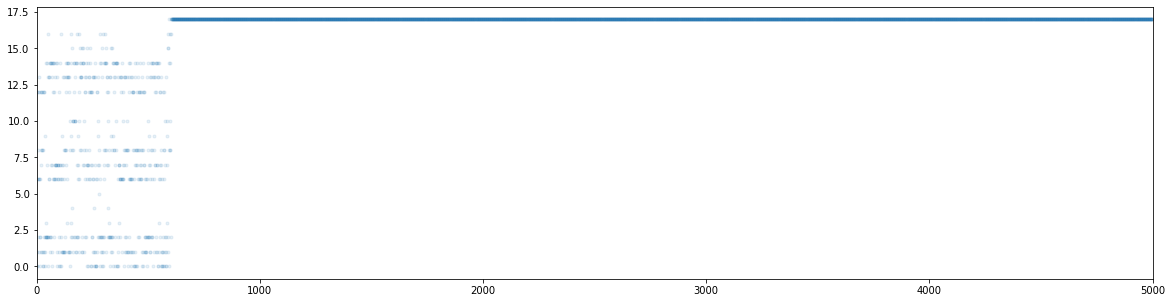

In [1922]:
plt.figure(figsize=(20,5)); ax=plt.subplot(111)
ax.plot(trainer.mem_obs_final, '.', alpha=.1)
ax.set_xlim(0,N)

In [1923]:
mem_Q_var_arr = np.array(mem_Q_var)

In [1924]:
mem_Q_var_flat = mem_Q_var_arr.reshape((N, -1))

(0.0, 5000.0)

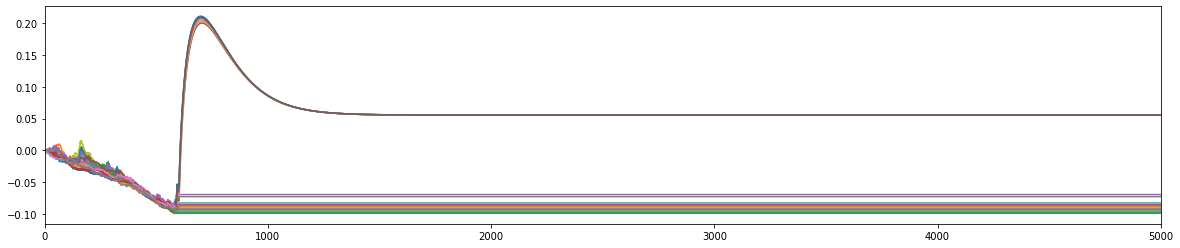

In [1925]:
plt.figure(figsize=(20,4)); ax=plt.subplot(111)
ax.plot(mem_Q_var_flat)
ax.set_xlim(0,N)

(0.0, 5000.0)

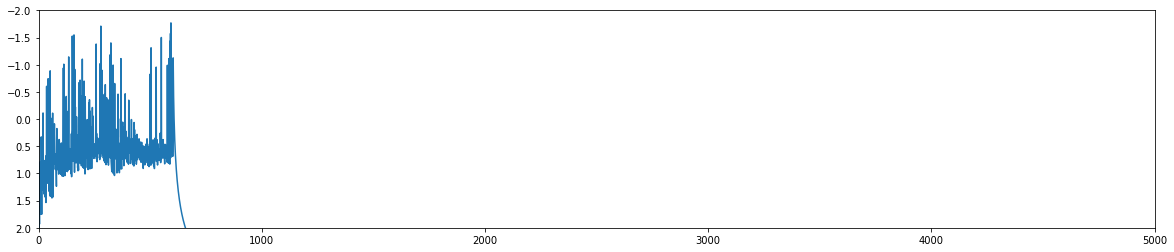

In [1926]:
plt.figure(figsize=(20,4))
ax=plt.subplot(111)
ax.plot(mem_KL)
ax.set_ylim(2,-2)
ax.set_xlim(0,5000)

(0.0, 5000.0)

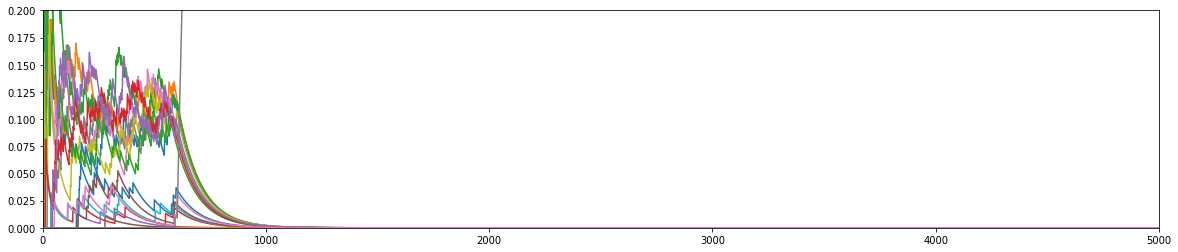

In [1927]:
plt.figure(figsize=(20,4))
ax=plt.subplot(111)
ax.plot(mem_p_eff.T)
ax.set_ylim(0,.2)
ax.set_xlim(0,5000)

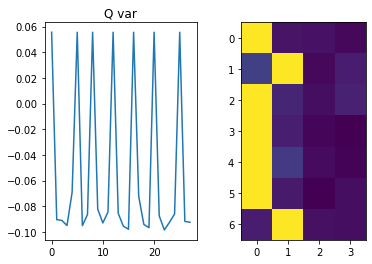

In [1928]:
plt.subplot(1,2,1)
plt.plot(agent.Q_var_tab.flatten())
plt.title('Q var')
plt.subplot(1,2,2)
plt.imshow(agent.Q_var_tab)

In [1929]:
trial=0
v_min=0
v_max = 0.16
savefigs = False

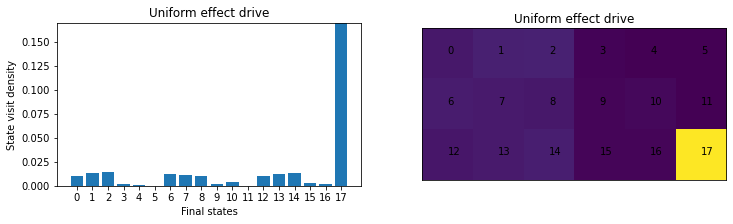

In [1930]:
plt.figure(figsize = (12,3))
ax = plt.subplot(1,2,1)
plt.bar(range(env.N_obs), nb_visits_final[trial] / N)
ax.set_xticks(range(18))
plt.xlabel('Final states')
plt.ylabel('State visit density')
plt.ylim([0,0.17])
plt.title('Uniform effect drive')

ax = plt.subplot(1,2,2)
plt.imshow(nb_visits_final[trial].reshape(3,6)/ N, vmin=v_min, vmax=v_max)
for j in range(6):
    for i in range(3):
        plt.text(j,i,6*i+j)

ax.set_xticks([])
ax.set_yticks([])
plt.title('Uniform effect drive')

if savefigs:
    plt.savefig('botteneck-uniform-drive.png', bbox_inches='tight')

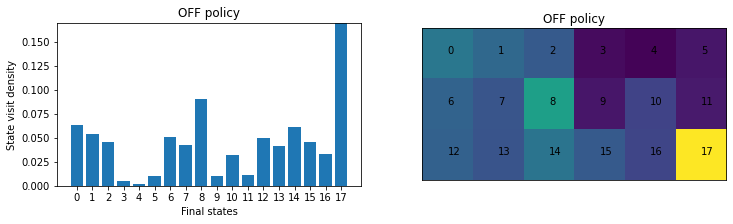

In [1931]:
#print(trainer.nb_visits_final)
plt.figure(figsize = (12,3))
ax = plt.subplot(1,2,1)
plt.bar(range(env.N_obs), nb_visits_final_OFF[trial]/ N)
ax.set_xticks(range(18))
plt.xlabel('Final states')
plt.ylabel('State visit density')
plt.ylim([0,0.17])
plt.title('OFF policy')

ax = plt.subplot(1,2,2)
plt.imshow(nb_visits_final_OFF[trial].reshape(3,6)/ N, vmin=v_min, vmax=v_max)
for j in range(6):
    for i in range(3):
        plt.text(j,i,6*i+j)

ax.set_xticks([])
ax.set_yticks([])
plt.title('OFF policy')

if savefigs:
    plt.savefig('botteneck-baseline.png')

0


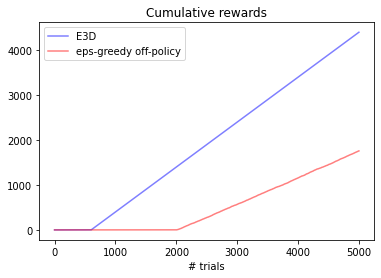

In [1932]:
for trial in range(NB_TRIALS):
    print(trial)
    if trial == 0:
        plt.plot(np.cumsum(mem_total_reward[trial]), alpha=0.5, label='E3D', color='blue')
    else:
        plt.plot(np.cumsum(mem_total_reward[trial]), alpha=0.5, color='blue')
    if trial == 0:
        plt.plot(np.cumsum(mem_total_reward_OFF[trial]), alpha=0.5, label='eps-greedy off-policy', color='red')
    else:
        plt.plot(np.cumsum(mem_total_reward_OFF[trial]), alpha=0.5, color='red')
    plt.legend()
    plt.title('Cumulative rewards')
    plt.xlabel('# trials')
    
if savefigs:
    plt.savefig('training-comparison.png', bbox_inches='tight')

In [1933]:
trainer.nb_trials

5000

In [1934]:
obs_nb_visit = np.zeros((env.N_obs, trainer.nb_trials))
obs_p = np.zeros((env.N_obs, trainer.nb_trials))
for obs in range(env.N_obs):
    obs_nb_visit[obs,:] = np.cumsum(np.array(trainer.mem_obs_final)==obs)
    obs_p[obs,:] = np.cumsum(np.array(trainer.mem_obs_final)==obs) / (np.arange(trainer.nb_trials)+1)
    

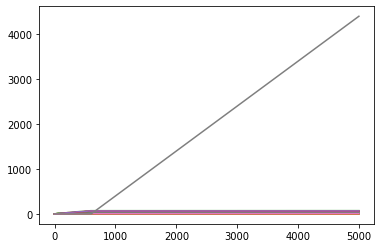

In [1935]:
_ = plt.plot(obs_nb_visit.T)

(0.0, 0.2)

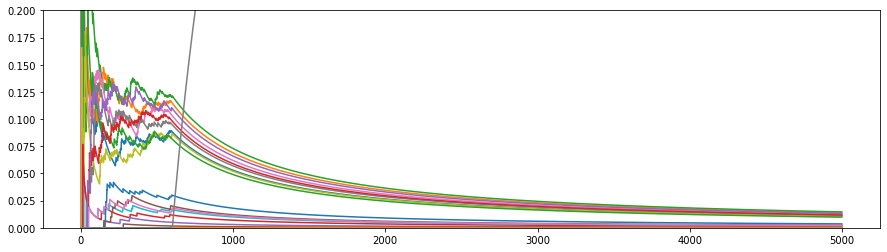

In [1936]:
plt.figure(figsize=(15,4))
plt.plot(obs_p.T)
plt.ylim((0,0.2))

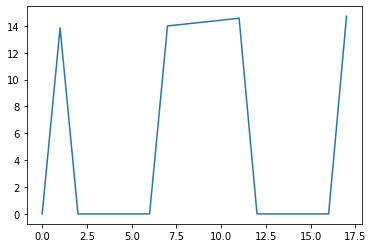

In [1937]:
plt.plot(trainer.obs_score)

In [1938]:
trainer.ref_probs

array([0.05882353, 0.05882353, 0.05882353, 0.05882353, 0.05882353,
       0.05882353, 0.05882353, 0.05882353, 0.05882353, 0.05882353,
       0.05882353, 0.        , 0.05882353, 0.05882353, 0.05882353,
       0.05882353, 0.05882353, 0.05882353])

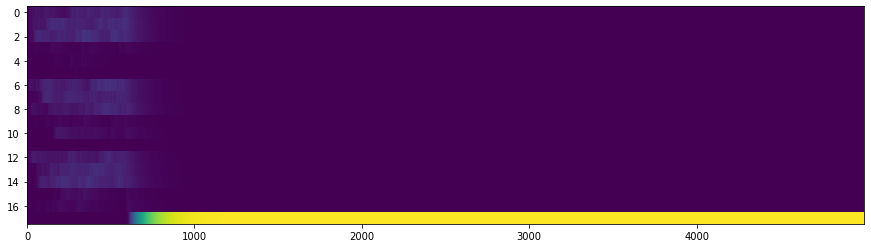

In [1939]:
plt.figure(figsize=(15,4))
_ = plt.imshow(mem_obs_score, aspect='auto', interpolation='nearest')

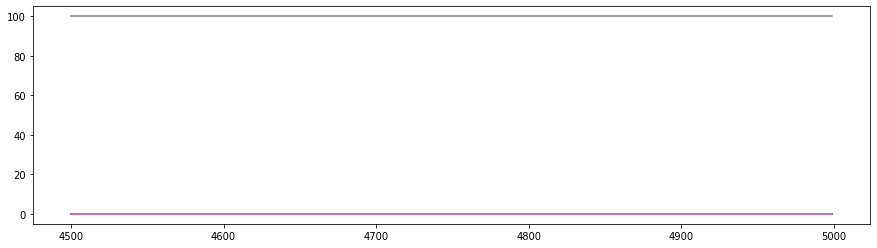

In [1940]:
plt.figure(figsize=(15,4))
plt.plot(range(4500,5000), mem_obs_score[:,4500:5000].T)

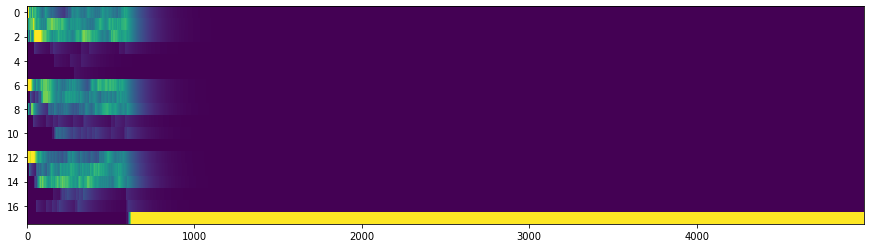

In [1941]:
plt.figure(figsize=(15,4))
_ = plt.imshow(mem_p_eff, aspect='auto', interpolation='nearest', vmin=0, vmax=0.2)

(4500.0, 5000.0)

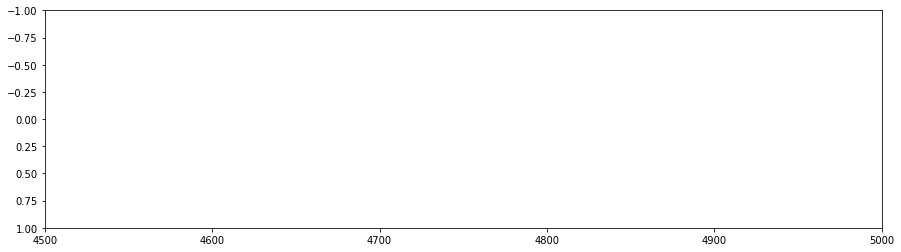

In [1942]:
plt.figure(figsize=(15,4))
ax=plt.subplot(111)
ax.plot(range(4500,5000), mem_KL[4500:5000])
ax.set_ylim(1,-1)
ax.set_xlim(4500,5000)

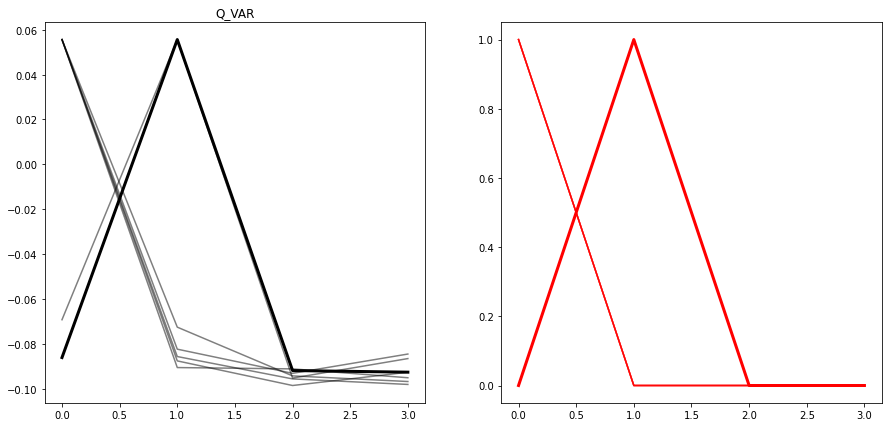

In [1943]:
#obs = trainer.agent.get_observation()
plt.figure(figsize=(15,7))
ax1=plt.subplot(1,2,1)
ax2=plt.subplot(1,2,2)
for obs in range(7):
    actions_set = None #trainer.set_actions_set()
    #print(actions_set)
    Q_obs = trainer.agent.set_Q_obs(obs, actions_set = actions_set)
    ax1.plot(Q_obs,'k',alpha=.5)    
    ax1.set_title('Q_VAR') # : MEAN RTG :' + str(m_rtg))
    ax2.plot(agent.softmax(obs, actions_set=actions_set), 'r', alpha=.5)
#ax1.plot((1,trainer.N_PART), (m_rtg, m_rtg), 'r')
ax1.plot(Q_obs,'k',linewidth=3)
ax2.plot(agent.softmax(obs, actions_set=actions_set), 'r', linewidth=3)

## TRIAL

1


Text(0.5, 1.0, 'TRIAL : ACTION')

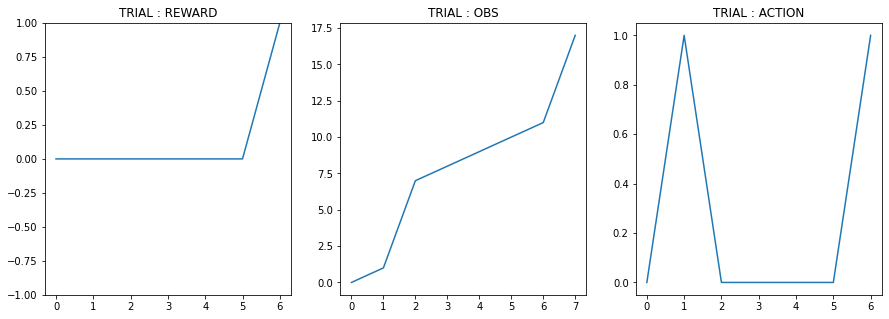

In [1944]:
%matplotlib tk
#agent.env=env
trainer.run_episode(render=True)

%matplotlib inline
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(trainer.reward_history)
plt.ylim(-1,1)
plt.title('TRIAL : REWARD')
plt.subplot(1,3,2)
plt.plot(trainer.trajectory)
print(trainer.total_reward)
plt.title('TRIAL : OBS')
plt.subplot(1,3,3)
plt.plot(trainer.action_history)
plt.title('TRIAL : ACTION')
#obs = trainer.agent.get_observation()
